In [1]:
# Set the matplotlib backend and make the plots a bit bigger
%matplotlib inline
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 6]
matplotlib.rc('text', usetex = True)

import sys

import re
from lmfit.models import GaussianModel, PolynomialModel, LorentzianModel, ExponentialModel, LinearModel
from lmfit import Parameters, fit_report, minimize, Model
from lmfit.model import save_modelresult, load_modelresult

import pandas as pd

import pyFAI
import numpy as np
import imageio
import matplotlib.pyplot as plt
sys.path.append("../../src/diamond_analysis")
sys.path.append("../../src/xrd")

from load_data import load_tiff, merge_quad23
from integrate_quads import integrate1d
from combine_quads import merge_four_quads
from peak_shapes import *
from fit_peaks import fit_diamond, sampleChi2, init_fits, fit_background

import logging
from stipcrawl import setup_logger
logger = setup_logger.logger
quad_scale = np.loadtxt("../../.data_LW03/instprm/quad_scale_LW03.txt")

wavelength = 1.3051 * 1e-10

### This notebook makes use of the pyFAI package to azimuthaly integrate XRD spectra. 
Documentation of the package can be found [here](https://pyfai.readthedocs.io/en/master/index.html)

In [2]:
# define the data directory
dir_data = "../../.data_LW03"

# the logbook file
logbook = "../../.data_LW03/logbook_LW03_subset.ods"

# the calibration .poni files created by Dioptas
poni_file_q0    = "../../.data_LW03/poni/Quad0_CeO2.poni"
poni_file_q1    = "../../.data_LW03/poni/Quad1_CeO2.poni"
poni_file_q2    = "../../.data_LW03/poni/Quad2_CeO2.poni"
poni_file_q3    = "../../.data_LW03/poni/Quad3_CeO2.poni"

poni_file_q0    = "../../.data_LW03/poni/Quad0_MS.poni"
poni_file_q1    = "../../.data_LW03/poni/Quad1_MS.poni"
poni_file_q2    = "../../.data_LW03/poni/Quad2_MS.poni"
poni_file_q3    = "../../.data_LW03/poni/Quad3_MS.poni"
poni_file_SACLA = "../../.data_SACLA/poni/Q_SACLA.poni"

# the mask files for the quad detectors
mask_q0     = "../../.data_LW03/mask/Quad0_ext.mask"
mask_q1     = "../../.data_LW03/mask/Quad1_ext.mask"
mask_q2     = "../../.data_LW03/mask/Quad2.mask"
mask_q3     = "../../.data_LW03/mask/Quad3.mask"
mask_SACLA  = "../../.data_SACLA/mask/SACLA_extensive.mask"

# define the pattern for a background file
pattern_runs = re.compile("r[0-9]*_bkgCorrected")

# define the azimuthal intyegrator objects from pyFAI
q0_ai   = pyFAI.load(poni_file_q0);
q1_ai   = pyFAI.load(poni_file_q1);
q2_ai   = pyFAI.load(poni_file_q2);
q3_ai   = pyFAI.load(poni_file_q3);

q_SACLA = pyFAI.load(poni_file_SACLA);

# load the masks as np arrays

q0_mask     = np.array(imageio.imread(mask_q0),dtype=int);
q1_mask     = np.array(imageio.imread(mask_q1),dtype=int);
q2_mask     = np.array(imageio.imread(mask_q2),dtype=int);
q3_mask     = np.array(imageio.imread(mask_q3),dtype=int);
SACLA_mask  = np.array(imageio.imread(mask_SACLA),dtype=int);

inst_file = '../../.data_LW03/instprm/LW03.instprm'
cif_file = '../../.data_LW03/cif/diamond.cif'

In [3]:
def fit_diamond(data, plot=False,C111_max=3.):

    background = PolynomialModel(degree=15, prefix='bkg_')
    pars = background.guess(data[1], x=data[0])

    peak1 = LorentzianModel(prefix='C111_')
    pars.update(peak1.make_params())

    pars['C111_center'].set(value=38.45, min=30, max=40)
    pars['C111_sigma'].set(value=np.random.normal(0.22,0.5),min=0.,max=C111_max)
    pars['C111_amplitude'].set(value=np.random.normal(3143,50))

    peak2 = LorentzianModel(prefix='C220_')
    pars.update(peak2.make_params())

    pars['C220_center'].set(value=63.9, min=60, max=67)
    pars['C220_sigma'].set(value=2.5, max=3.7)
    #pars['C220_amplitude'].set(value=np.random.normal(1000,50), min=0.)
    pars['C220_amplitude'].set(value=np.random.normal(1000,50), min=0.)
    

    PET_peak = LorentzianModel(prefix='PET_')
    pars.update(PET_peak.make_params())

    pars['PET_center'].set(value=27, min=26, max=29.)
    pars['PET_sigma'].set(value=1.5, max=2.5)
    #pars['PET_amplitude'].set(value=np.random.normal(1000,50), min=0.)
    pars['PET_amplitude'].set(value=np.random.normal(1000,50), min=0.,max=0.1)

    model = peak1 + peak2 + background + PET_peak
    #model = diamond_peaks + background + PET_peak

    init = model.eval(pars, x=data[0])
    out = model.fit(data[1], pars, x=data[0])
    #print(out.fit_report())

    # print(out.fit_report)
    if plot==True:

        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes[0].plot(data[0], data[1],label='XRD data')
        #axes[0].plot(data[0], init, '--', label='initial fit')
        axes[0].plot(data[0], out.best_fit, '-', label='best fit')
        axes[0].set_ylabel(r'$I$')
        axes[0].set_xlabel(r'$2\theta$')
        axes[0].legend()

        comps = out.eval_components(x=data[0])
        #print(out.params.valuesdict())

        axes[1].plot(data[0], data[1])
        axes[1].plot(data[0], comps['C111_'], '--', label='Peak 111')
        axes[1].plot(data[0], comps['C220_'], '--', label='Peak 220')
        axes[1].plot(data[0], comps['bkg_'], '--', label='Background')
        axes[1].plot(data[0], comps['PET_'], '--', label='PET peak')
        #axes[1].set_ylabel(r'$I [au]$')
        axes[1].set_xlabel(r'$2\theta$')
        axes[1].legend()

        plt.show() 

    else:
        fig = None
    return out, fig

def plotBestFits(runs=[182,186,188,190,192,298,286]):
    fits            = [[]] * len(runs)
    fig             = plt.figure(figsize=(12, 40))
    gs              = fig.add_gridspec(len(runs)*3, 2)
    probingTime     = {182:9.,186:8.,188:7.,190:10.,192:11.,289:12,286:12}

    for run_id, run in enumerate(runs):
        data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
        comps               = fits[run_id].params
        try:
            print(comps["C111_center"])
            print(comps["C111_sigma"])
            #print(comps)
        except:
            print(comps["peaks_C220_center"])
            print(comps["peaks_C220_sigma"])
        #print(comps["C111_amplitude"].value/comps["C220_amplitude"].value)

        t                   = int(probingTime[run])
        t_id                = (int(t-np.min(list(probingTime.values()))))
        comps               = fits[run_id].eval_components(x=data[0])
        #print(out.params.valuesdict())
        ax1                 = fig.add_subplot(gs[t_id*3:t_id*3+2, 0:0+1])

        ax1.plot(data[0], data[1],label=f'XRD data run {run}')
        #axes[0].plot(data[0], init, '--', label='initial fit')
        ax1.plot(data[0], fits[run_id].best_fit, '-', label='best fit')
        ax1.set_ylabel(r'$I$ [\textit{au}]',fontsize=20)
        if run_id == len(runs)-1:
            ax1.set_xlabel(r'$2\theta$ [\textit{deg}]',fontsize=20)
        #axes[t_id,0].plot(data[0], comps['bkg_'], '--', label='Background',color='r')
        ax1.legend()
        ax1.axes.yaxis.set_ticks([])
        
        ax2                 = fig.add_subplot(gs[t_id*3:t_id*3+3, 1:1+1])
        ax2.plot(data[0], data[1])
        try:
            ax2.plot(data[0], comps['peaks_'], '--', label='Peaks')
        except:
            ax2.plot(data[0], comps['C111_'], '--', label='Peak 111')
            ax2.plot(data[0], comps['C220_'], '--', label='Peak 220')
        ax2.plot(data[0], comps['bkg_'], '--', label='Background')
        ax2.plot(data[0], comps['PET_'], '--', label='PET peak')
        ax2.axes.yaxis.set_ticks([])
        #axes[1].set_ylabel(r'$I [au]$')
        if run_id == len(runs)-1:
            ax2.set_xlabel(r'$2\theta$ [\textit{deg}]',fontsize=20)
        ax2.legend()

        ax3                 = fig.add_subplot(gs[t_id*3+2:t_id*3+3, 0:0+1])
        residuals           = (fits[run_id].best_fit - data[1])/np.max(data[1])
        ax3.plot(data[0],residuals)
    fig.savefig(f'../../.data_LW03/figures/bestFits.svg')
    plt.show() 


##### Load SACLA data

In [62]:
SACLA_target_dict   = {0:'PET75',1:'AL/PET100',2:'PET1000',3:'PET38/Al6.5'}
SACLA_data          = \
    np.array([[23,25,27,29,31,33,35,76,78,80,82,146,148,150,152,155,157,159,163,165,167,169,171,173,182,185,188,192,195,199,204,211,213,215,217,222,224,226,307,309,311,313,316,320],\
    [1162359,1162361,1162363,1162365,1162367,1162369,1162371,1162415,1162417,1162419,1162421,1162485,1162487,1162489,1162491,1162494,1162496,1162498,1162502,1162504,1162506,1162508,1162510,1162512,1162521,1162524,1162527,1162531,1162534,1162537,1162540,1162547,1162549,1162551,1162553,1162558,1162560,1162562,1162645,1162647,1162649,1162651,1162654,1162658],\
    [1162358,1162360,1162362,1162364,1162366,1162368,1162370,1162414,1162416,1162418,1162420,1162484,1162486,1162488,1162490,1162493,1162495,1162497,1162501,1162503,1162505,1162507,1162509,1162511,1162520,1162523,1162526,1162530,1162533,1162536,1162539,1162546,1162548,1162550,1162552,1162557,1162559,1162561,1162644,1162646,1162648,1162650,1162653,1162657],\
    [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1162522,1162525,1162528,None,1162535,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None],\
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.2,0.2,0.2,0.2,0,0,0,0,0,0,0,0,0],\
    [2,5,4,3,3,4,5,5,5,5,6,6,6,10,8,8,12,7,4,5,4,3,6,10,3,3,3,4,7,5,5,3,4,5,2,2,2,4,5,8,10,11,13,15],\
    [1.24E+01,9.68E+00,1.20E+01,1.32E+01,8.34E+00,9.30E+00,1.07E+01,3.41E+00,1.95E+00,4.45E+00,7.69E+00,2.91E+00,5.90E+00,4.00E+00,3.98E+00,3.96E+00,3.40E+00,2.79E+00,2.83E+00,2.39E+00,1.95E+00,2.41E+00,2.31E+00,2.32E+00,1.55E+01,1.32E+01,1.74E+01,1.60E+01,1.62E+01,1.74E+01,2.01E+01,2.45E+00,2.01E+00,2.03E+00,2.51E+00,1.87E+00,3.03E+00,2.88E+00,6.80E+00,6.05E+00,7.16E+00,7.54E+00,6.59E+00,4.88E+00],\
    [0.8,0.8,0.8,0.8,0.6,0.6,0.6,0.2,0.15,0.25,0.4,0.2,0.3,0.3,0.25,0.2,0.2,0.15,0.15,0.13,0.13,0.13,0.13,0.13,0.13,0.2,0.5,1,0.2,1,0.13,0.13,0.13,0.13,0.13,0.13,0.2,0.2,0.4,0.4,0.4,0.4,0.4,0.4],\
    [0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,3,3,3,3,3,3,3,0,0,0,0,0,0]]
    )
#for i in SACLA_data:
#   print(len(i))    

SACLA_shots         = pd.DataFrame(SACLA_data.T,columns=['run','shot_id','ref_id','post_id','Xray_attenuation',\
   'delay','E_on_sample','laser_transmission','target'])

datatypes           =  [int, int, int, int, float, int, float, float, int]

#[SACLA_shots[key] = SACLA_shots[key].convert_dtypes(datatypes[id]) for id, key in enumerate(SACLA_shots.keys())]

for id, key in enumerate(SACLA_shots.keys()):
    SACLA_shots[key] = SACLA_shots[key].convert_dtypes(datatypes[id])




In [59]:
SACLA_shots

,run,shot_id,ref_id,Xray_attenuation,delay,E_on_sample,laser_attenuation,target
0,23,1162359,1162358,0,2,12.4,0.8,0
1,25,1162361,1162360,0,5,9.68,0.8,0
2,27,1162363,1162362,0,4,12.0,0.8,0
3,29,1162365,1162364,0,3,13.2,0.8,0
4,31,1162367,1162366,0,3,8.34,0.6,0
5,33,1162369,1162368,0,4,9.3,0.6,0
6,35,1162371,1162370,0,5,10.7,0.6,0
7,76,1162415,1162414,0,5,3.41,0.2,1
8,78,1162417,1162416,0,5,1.95,0.15,1
9,80,1162419,1162418,0,5,4.45,0.25,1


In [ ]:
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
#for run in []:
#    merge_SACLA(run, dir_data, q_ai,mask)

<Parameter 'C111_center', value=38.162391162660725 +/- 0.00589, bounds=[30:40]>
<Parameter 'C111_sigma', value=1.3354871960837413 +/- 0.0127, bounds=[0:inf]>
<Parameter 'C111_center', value=38.04673530802512 +/- 0.00708, bounds=[30:40]>
<Parameter 'C111_sigma', value=1.462587147845357 +/- 0.0153, bounds=[0:inf]>
<Parameter 'C111_center', value=38.05314087649285 +/- 0.0107, bounds=[30:40]>
<Parameter 'C111_sigma', value=1.9346425909182687 +/- 0.0257, bounds=[0:inf]>
<Parameter 'C111_center', value=37.89522090916528 +/- 0.00588, bounds=[30:40]>
<Parameter 'C111_sigma', value=1.4672205934364926 +/- 0.0128, bounds=[0:inf]>
<Parameter 'C111_center', value=37.11825125153564 +/- 0.00522, bounds=[30:40]>
<Parameter 'C111_sigma', value=1.0207753953235699 +/- 0.0101, bounds=[0:inf]>
<Parameter 'C111_center', value=38.262389678408546 +/- 0.0214, bounds=[30:40]>
<Parameter 'C111_sigma', value=0.9980147016491663 +/- 0.0423, bounds=[0.0:1.0]>


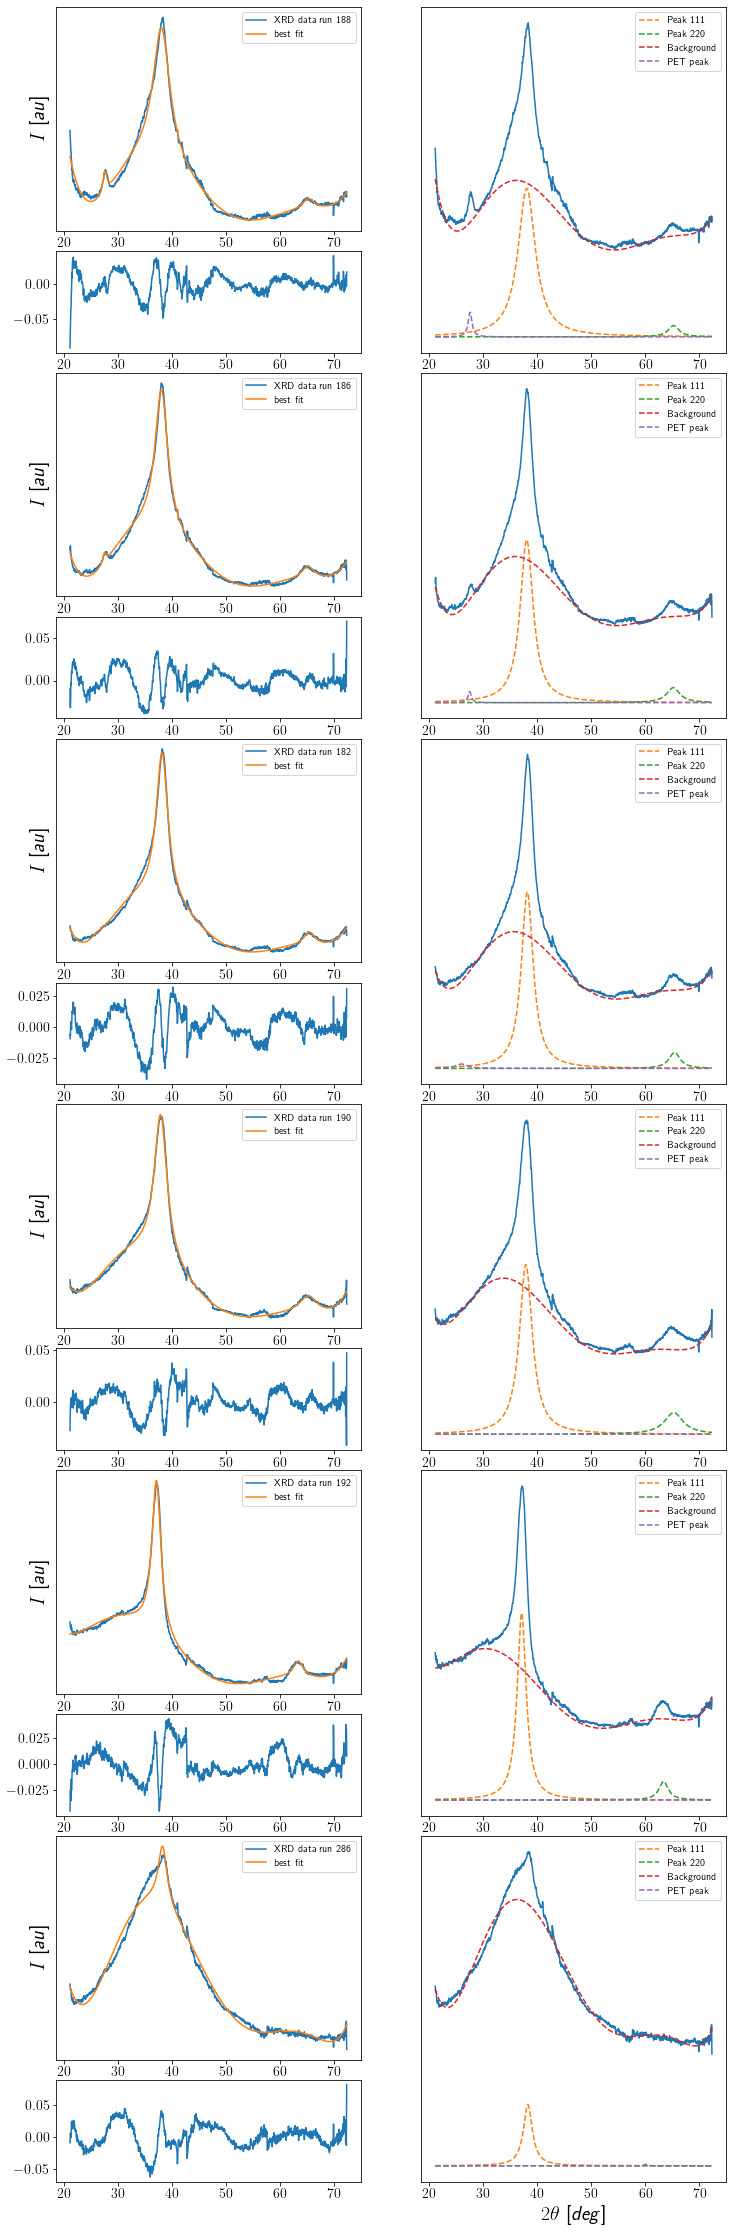

In [4]:
#init_fits(runs=[286],C111_max=1.)
#sampleChi2(runs=[286],rounds=200,C111_max=1.)
#sampleChi2(runs=[182,186,188,190,192],rounds=10)
plotBestFits([182,186,188,190,192,286])

In [11]:
fdafds

NameError: name 'fdafds' is not defined

In [ ]:
runs            = [182,186,188,190,192]
fits            = [load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav') for run in runs]
fit = fits[0]

In [ ]:
from crystalite_size import crystalite_size
wavelength = 1.3051 * 1e-10

runs            =[182,186,188,190,192]
fits            = [load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav') for run in runs]
print(fit.params["C111_center"].value/2.,)

#[crystalite_size(fit,wavelength=wavelength, K=0.94) for fit in fits]

19.081195581330363


In [ ]:
beta1, beta2                    = np.deg2rad(fit.params["C111_sigma"].value), np.deg2rad(fit.params["C220_sigma"].value)
beta1_err, beta2_err            = np.deg2rad(fit.params["C111_sigma"].stderr), np.deg2rad(fit.params["C220_sigma"].stderr)
y_values                        = np.array([np.log(beta1),np.log(beta2)])
y_err                           = np.array([np.log(beta1_err),np.log(beta2_err)])
   
theta1, theta2                  = fit.params["C111_center"].value/2., fit.params["C220_center"].value/2.
theta1_err, theta2_err          = fit.params["C111_center"].stderr/2., fit.params["C220_center"].stderr/2.
x_values                        = np.array([1/np.cos(theta1), 1/np.cos(theta2)])
x_err                           = np.array([1/np.cos(theta1_err), 1/np.cos(theta2_err)])

    ### using lmfit to fit a linear model to the data points 
line                            = LinearModel()
pars = line.guess(y_values, x=x_values)
pars.update(line.make_params())

init = line.eval(pars, x=x_values)
out = line.fit(y_values, pars, x=x_values)
#print(out.fit_report())


out.params
wavelength

1.3051e-10

In [ ]:
neus_r182           = np.loadtxt("../../.data_LW03/VISAR/Visar_v2_r182.txt")
time_r182           = neus_r182[:,0]
v2_r182             = neus_r182[:,1]
import pandas as pd
df  = pd.read_csv('../../.data_LW03/cif/diamond.txt')

In [ ]:
def waterfallPlot(runs=[182,186,188,190,192,298],fig = None, axes = None):
    if fig == None:
        fig, axes           = plt.subplots(figsize=(8, 7))
    probingTime         = {182:9.,186:8.,188:7.,190:10.,192:11.,298:13.}
    fits                = [[]] * len(runs)
    colors              = ['gold','deepskyblue','deeppink','darkgreen','darkred','k']
    df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
    peak_positions, scaled_int  = df['2theta'],df['F']
    axes.axvline(x = peak_positions[0], color = 'k',linestyle='dashed',linewidth=0.9)
    axes.axvline(x = peak_positions[1], color = 'k',linestyle='dashed',linewidth=0.9)
    #labels = ['7ns','8ns','9ns','10ns','11ns']
    for run_id, run in enumerate(runs):
        fits[run_id]        = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
        
        shift               = 0
        if run==289:
            shift=-5
        t                   = int(probingTime[run])
        t_id                = (int(t-np.min(list(probingTime.values()))))
        if run==298:
            t_id            = len(runs) - 1
        data                = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
        comps               = fits[run_id].eval_components(x=data[0])
        
        axes.plot(data[0], data[1]/np.max(data[1]) - t_id - shift,color=colors[t_id], label=f'{t} ns')
        #axes.plot(data[0], comps['C111_']/np.max(data[1]) - t_id, '--', label='Peak 111',c='r')
        #axes.plot(data[0], comps['C220_']/np.max(data[1]) - t_id, '--', label='Peak 220',c='b')
        axes.plot(data[0], comps['bkg_']/np.max(data[1]) - t_id, '--',c='r',linewidth=0.9)
        #axes.plot(data[0], comps['PET_']/np.max(data[1]) - t_id, '--', label='PET peak',c='grey')
        ypos    = (data[1]/np.max(data[1]) - t_id)[-1] + 0.2
        xpos    = 70.
        axes.text(xpos, ypos, f'{t} ns', horizontalalignment='center',verticalalignment='center',fontsize=22,color=colors[t_id])
        
    axes.tick_params(left=False, labelleft=False)
    axes.set_ylabel(r'$I$ [\textit{a.u.}]',fontsize=22)
    axes.set_xlabel(r'Scattering angle $2\theta$ [\textit{deg}]',fontsize=22)
    #axes.spines['bottom'].set_color('white')
    axes.spines['top'].set_color('white') 
    axes.spines['right'].set_color('white')
    #axes.spines['left'].set_color('white')
    axes.xaxis.set_tick_params(labelsize=25)
    axes.yaxis.set_tick_params(labelsize=25)
    axes.text(peak_positions[0]+0.5, 1.2, f'(111) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(peak_positions[1]+0.5, 1.2, f'(220) Peak', horizontalalignment='left',verticalalignment='center',fontsize=20,color='k')
    axes.text(27.55-0.2, 1.2, f'Cold\nPET Peak', horizontalalignment='right',verticalalignment='center',fontsize=20,color='k')
    #plt.savefig('../../.data_LW03/figures/waterfall.pdf')
    #matplotlib.rcParams['figure.figsize'] = [8, 6]
    matplotlib.rc('text', usetex = True)
    axes.axvline(x = 27.55,ymin=0.62, color = 'k',linestyle='dashed',linewidth=0.9)

    #import tikzplotlib
    #tikzplotlib.save('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.tex')
    #tikzplotlib.get_tikz_code(figure='gcf',filepath="waterfall.tex",override_externals=True)#,strict=True,wrap=False)
    #matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    #plt.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')
    plt.show()

In [ ]:
visar_path = "/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Git/PhD_Git/PhD_Thesis/.data_LW03/VISAR/"

In [ ]:
def load_visar(run : int, visar_path : str, sweep : float) -> [np.array, np.array, np.array, np.array, np.array]:
    """
    :param run:         number of the run to load the VISAR data for
    :param visar_path:  path of the location of VISAR raw image and txt data
    :param sweep:       sweep time of the streak camera
    :return:            V1 the image arrays of the VISAR images
    :return:            lineout, time, velocity, vel_err
    """
    file_name_raw = "r" + str(run) + "_V1.tif"
    file_name_txt = "Visar_v1_r" + str(run) + ".txt"
    logger.debug(f"Trying to load raw data at: \nV1: {visar_path + file_name_raw}")
    try:
        V = plt.imread(visar_path + file_name_raw)
        logger.info(f"Loading raw data successful")
    except:
        logger.error(f"Apparently no VISAR raw data in {visar_path + file_name_raw}")
        return None, None
    try:
        data = np.loadtxt(visar_path + file_name_txt)
        logger.info(f"Loading Neutrino data successful")
    except:
        logger.error(f"Apparently no Neutrino data in {visar_path}")
        return None, None
    ### Do the vertical lineouts
    lineout = np.sum(V,axis=1)

    ### set the time and v/v_err data
    time = data[:,0]
    velocity = data[:,1]
    vel_err = data[:,2]
    return V, lineout, time, velocity, vel_err

[~]  Loading raw data successful
INFO:stipcrawl.setup_logger:Loading raw data successful
[~]  Loading Neutrino data successful
INFO:stipcrawl.setup_logger:Loading Neutrino data successful


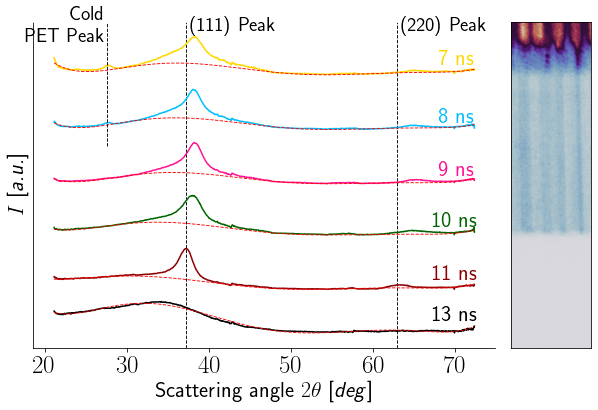

In [ ]:
logger.setLevel(logging.INFO)
V182, LO, t_r182, v_r18, v_err_r1822  = load_visar(182,visar_path,20.)
ROI                         = V182[:,550:800]

#time = np.linspace(0,20.,len(LO_1))
fig                         = plt.figure(figsize=(10,6))
gs                          = fig.add_gridspec(1, 6)

ax0                         = fig.add_subplot(gs[0:1, 0:5])
ax1                         = fig.add_subplot(gs[0:1, 5:6])
ax1.imshow(ROI,cmap="twilight")
ax1.set_xticks([])
ax1.set_yticks([])
waterfallPlot(fig=fig, axes=ax0)
#axarr[0,1].imshow(V190_2)
#axarr[1,0].plot(time, LO_1)
#axarr[1,1].plot(time, LO_2)
#plt.show()

In [ ]:
r182 =          np.loadtxt(f"../../.data_LW03/lineouts/r{182}_Q23.xy").T
print(f"Total angular coverage goes from {r182[0,0]} to {r182[0,-1]}")
atoms_per_uc        = 8.
u                   = 1.66053904e-27
mass_per_atom       = 12*u*1000
mass_per_uc_gramm   = atoms_per_uc * mass_per_atom
n                   = 1

runs=[182,186,188,190,192]
probingTime     = {182:9.,186:8.,188:7.,190:10.,192:11.}

for run_id, run in enumerate(runs):
    fit         = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
    print(fit.best_values["C111_center"])
    theta               = fit.best_values["C111_center"]
    d                   = n * (wavelength * 10)/ (2*np.sin(np.deg2rad(theta)/2.))
    a_cm                = d * np.sqrt(3)
    vol_gcc             = a_cm**3
    rho                 = mass_per_uc_gramm / vol_gcc
    tmp                 = fit.params["C111_center"].stderr
    print(f"Run is: {run}, stderr is: {tmp}")
    #rho_err             = np.sqrt((mass_per_uc_gramm)/((np.sqrt(3)*wavelength*10)**3)\
    #                    *8*3*(np.sin(np.deg2rad(theta)/2.))**2*np.cos(np.deg2rad(theta)/2.)\
    #                    * (fit.params["C111_center"].stderr)**2)
    
    #print(f"Density at time delay {probingTime[run]} is {rho} +/- {rho_err}")

#rho_C=8*M_C/UC_volume_C

Total angular coverage goes from 21.125430507995922 to 72.32085688075271
38.16492784490258
Run is: 182, stderr is: 0.00589919339914646
38.04673530802512
Run is: 186, stderr is: 0.007076381117043412
38.05314087649285
Run is: 188, stderr is: 0.010658776669114817
37.89522090916528
Run is: 190, stderr is: 0.00587794810830576
37.11825125153564
Run is: 192, stderr is: 0.005217057640529357


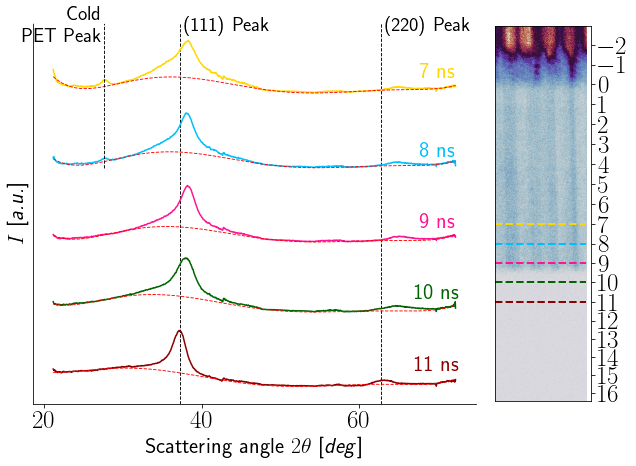

In [ ]:
from scipy.interpolate import interp1d
matplotlib.rc('font', weight='bold')

fig                         = plt.figure(figsize=(10,7))
gs                          = fig.add_gridspec(1, 5)

ax0                         = fig.add_subplot(gs[0:1, 0:4])
ax1                         = fig.add_subplot(gs[0:1, 4:5])
ax1.imshow((ROI),cmap="twilight",interpolation='nearest')
ax1.set_xticks([])
#line                        = matplotlib.lines.Line2D([0,1],[0,1],marker=">")

ticksPos                       = np.arange(len(t_r182))
### interpolate to map y values postions to the corresponding tick position
labelMapper                    = interp1d(t_r182, ticksPos)

### get the positions of where we have integer values for the y value
tMin, tMax                     = int(t_r182.min()), int(t_r182.max())
tickLables                     = np.arange(tMin,tMax+1)

#polynomial                     = np.poly1d([-2.,1.52475e-02,9.14541e-06,-5.96076e-09])

tickPositions = [labelMapper(y_value) for y_value in tickLables] 
ax1.set_yticks(tickPositions)
ax1.set_yticklabels([f"${label}$" for label in tickLables],ha='left')
ax1.yaxis.tick_right()
colors = ['gold','deepskyblue','deeppink','darkgreen','darkred','k']

for id, time in enumerate([7,8,9,10,11]):
        ax1.hlines(y=labelMapper(time), xmin=0, xmax=250, linewidth=2, color=colors[id],linestyle='--')

ax1.yaxis.set_tick_params(labelsize=25)
matplotlib.rc('text', usetex = True)
waterfallPlot(fig=fig,axes=ax0,runs=[182,186,188,190,192])
ax0.set_yticks([])
fig.tight_layout()
fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.pdf')

fig.savefig('/home/benjamin/Nextcloud/Work/W_PhD/W_PhD_Articles/Heuser_ND_recovery/figures/waterfall.eps')

In [ ]:
df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
print(f'Theoretical intensity is: {df.iloc[0]["I"]/df.iloc[1]["I"]}')
for run_id, run in enumerate([182,186,188,190,192]):
    fit         = load_modelresult( f'../../.data_LW03/fits/r{run}__modelresult.sav')
    print(f'Amplitute C111 is: {fit.best_values["C111_amplitude"]}\nAmplitute C220 is: {fit.best_values["C220_amplitude"]}\nRatio is: {fit.best_values["C111_amplitude"]/fit.best_values["C220_amplitude"]}')

Theoretical intensity is: 3.4715194806051413
Amplitute C111 is: 1683.5509057502125
Amplitute C220 is: 201.13022413585725
Ratio is: 8.370452093828652
Amplitute C111 is: 1579.134956886243
Amplitute C220 is: 146.94416502419804
Ratio is: 10.746496511965608
Amplitute C111 is: 1352.727637491231
Amplitute C220 is: 65.27615683177999
Ratio is: 20.723150735992007
Amplitute C111 is: 1478.2856140117237
Amplitute C220 is: 270.6475499240235
Ratio is: 5.462032131555263
Amplitute C111 is: 1049.417240529108
Amplitute C220 is: 107.40425339499315
Ratio is: 9.770723294074205


In [ ]:
df                  = pd.read_csv('../../.data_LW03/cif/diamond.txt')
df

,h,k,l,d(angstrom),F(real),F(imag),F,2theta,I,M,ID(lambda),Phase
0,1,1,1,2.043820,10.807323,-10.762347,15.25210,37.23873,100.00000,8,1,1
1,2,2,0,1.251579,12.043767,0.038663,12.04380,62.84992,28.80583,12,1,1
2,3,1,1,1.067350,5.089139,5.125703,7.22303,75.37782,14.30697,24,1,1
3,4,2,2,0.722599,4.771778,0.020717,4.77182,129.12626,6.93078,24,1,1
4,3,3,1,0.812132,2.450871,-2.430824,3.45191,106.93180,2.56460,24,1,1
5,4,0,0,0.885000,6.833784,0.026978,6.83384,95.01142,2.44259,6,1,1
6,2,2,2,1.021910,-0.005629,1.533497,1.53351,79.36893,0.19697,8,1,1


In [ ]:
df.iloc[0]["I"]/df.iloc[1]['I']

3.4715194806051413

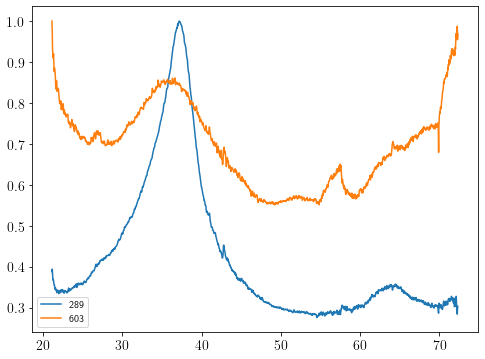

In [ ]:
r286_Q23 = np.loadtxt("../../.data_LW03/lineouts/r286_Q23.xy").T
r289_Q23 = np.loadtxt("../../.data_LW03/lineouts/r289_Q23.xy").T
r298_Q23 = np.loadtxt("../../.data_LW03/lineouts/r298_Q23.xy").T
r591_Q23 = np.loadtxt("../../.data_LW03/lineouts/r591_Q23.xy").T
r192_Q23 = np.loadtxt("../../.data_LW03/lineouts/r192_Q23.xy").T

#plt.plot(r286_Q23[0], r286_Q23[1]/np.max(r286_Q23[1]),label='286')
plt.plot(r289_Q23[0], r289_Q23[1]/np.max(r289_Q23[1]),label='289')
run         = 603
file        = "../../.data_LW03/lineouts/r" + str(run) + "_Q23.xy"
r_data      = np.loadtxt(file).T
plt.plot(r_data[0], r_data[1]/np.max(r_data[1]), label=str(run))

plt.legend()

In [ ]:
r289_Q23

In [ ]:
plt.plot(ticksPos,t_r182)

In [ ]:
runs                = [182,186,188,190,192,289]
d_111_ambient       = 2.04382 
d_220_ambient       = 1.25158
peak_ratios         = np.zeros(len(runs))
d_C111              = np.zeros(len(runs))
d_C220              = np.zeros(len(runs))
strain_111          = np.zeros(len(runs))
strain_220          = np.zeros(len(runs))

for run_id, run in enumerate(runs):
    result = load_modelresult(f'../../.data_LW03/fits/r{run}__modelresult.sav')
    param_dict              = result.params.valuesdict()
    peak_ratios[run_id]     = param_dict['C220_amplitude'] / param_dict['C111_amplitude']

    d_C111[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C111_center'] / 2.)))
    d_C220[run_id]          = wavelength / (2. * np.sin( np.deg2rad(param_dict['C220_center'] / 2.)))

    strain_111[run_id]      = np.abs(d_111_ambient - d_C111[run_id] * 1e9) / d_111_ambient
    strain_220[run_id]      = np.abs(d_220_ambient - d_C220[run_id] * 1e9) / d_220_ambient

    #data            = np.loadtxt(f"../../.data_LW03/lineouts/r{run}_Q23.xy").T
    #fits[run_id]    = fit_diamond(data)
    #save_modelresult(fits[run_id], f'../../.data_LW03/fits/r{run}__modelresult.sav')

In [ ]:
d_C111 *1e9

In [ ]:
d_C220 * 1e9

In [ ]:
plt.scatter(probing_times, strain_111, label='Strain 111 peak')
plt.scatter(probing_times, strain_220, label='Strain 220 peak')
plt.legend()

In [ ]:
peak_positions, scaled_int  = peaks_from_file('../../.data_LW03/cif/diamond.txt')
theoretical_int             = scaled_int[1] / scaled_int[0]
print(theoretical_int)

In [ ]:
peak_positions

In [ ]:
plt.plot(r182_Q23[0],r182_Q23[1])
out, param_dict = fit_double_peak(r182_Q23)
print(fit_report(out))
plt.plot(r182_Q23[0],lin_gauss_2lorentzian(r182_Q23[0],*list(param_dict.values())))

In [ ]:
param_dict['scale']

In [ ]:
list(param_dict.values())